# Итоговый проект

Представлен датасет из более 18000 песен. Для каждой песни приведены 15 характеристик: название, темп, продолжительность, популярность и так далее.

Назовём необходимые и самые значимые столбцы для анализа песни:

**song_name** - название песни

**song_popularity** - популярность песни

**song_duration_ms** - продолжительность песни в миллисекундах

**acousticness**  - акустика

**danceability** - "танцевальность"

**energy** - "энергичность"

**instrumentalness** - "инструментальность"

**loudness** - громкость

**tempo** - темп

**audio_valence** - сочетание звуков

# Задача 1

Для начала обучим **первую модель**, которая будет просто определять самые важные параметры, от которых больше всего зависит *популярность* песни.


In [32]:
# Подключаем все необходимые библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Загружаем данные
data = pd.read_csv("song_data.csv")

В качестве обучаемой модели будет исполльзоваться алгоритм Random Forest для более точного обучения и определения важности параметров. Random_state возьмём 42 для статичности получаемой информации.

In [ ]:
# В обработке данных нет необходимости, поэтому сразу переходим к обучению модели
X = data.drop(columns=["song_name", "song_popularity"])  # Признаки
y = data["song_popularity"]  # Целевая переменная

# Обучение модели
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

Для определения важности признаков воспользуемся функцией feature_importances_ из sklearn.

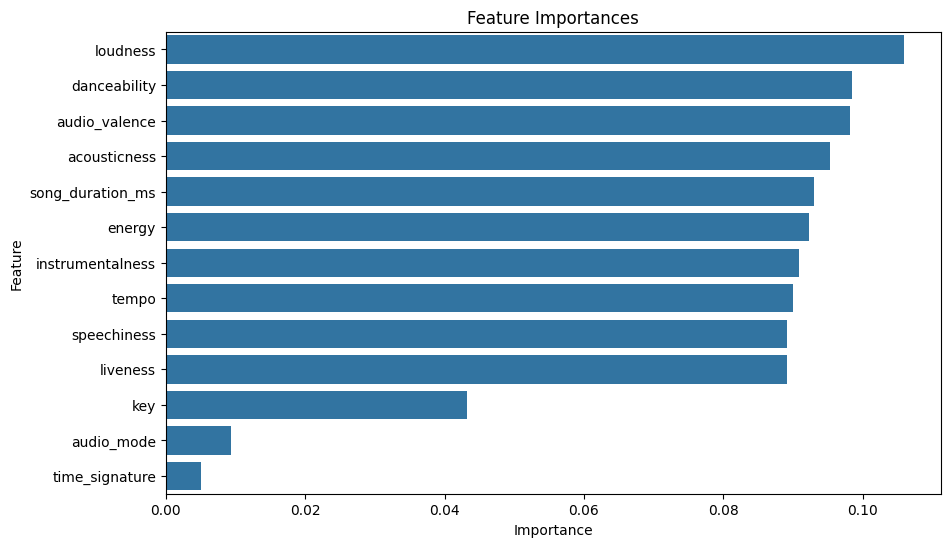

In [ ]:
# Анализ важности признаков
feature_importances = model.feature_importances_
features = X.columns

# Визуализация важности признаков
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.show()


По полученным результатам можно заметить, что 3 самых важных параметра для популярности песни оказались: "танцевальность", сочетание звуков и громкость.

# Задача 2

Теперь попробуем кластеризовать наши данные, разбить их на группы по самым важным для популярности песни параметрам (из задачи 1).

Но для начала определим, на сколько кластеров рационально разбить наши данные.

[33998727704461.492, 21686438073363.594, 14790190329734.246, 10762517080990.86, 7876160302676.852, 6088512270105.768, 4770179615275.908, 3772647160741.2637]


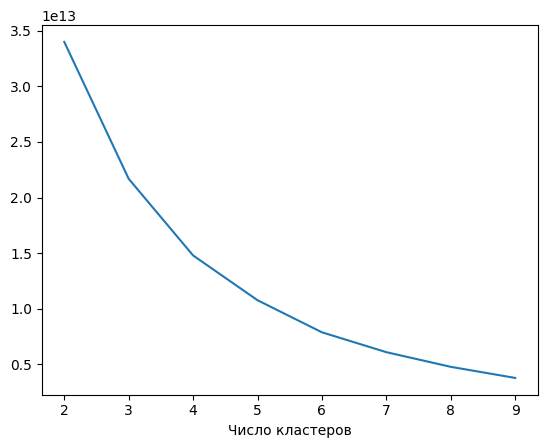

In [33]:
# Определяем оптимальное количество кластеров
cl = data.drop(['song_name'], axis=1)
criteries = []
for k in range(2,10):
  kmeansModel=KMeans(n_clusters=k, random_state=42)
  kmeansModel.fit(cl)
  criteries.append(kmeansModel.inertia_)
print(criteries)
plt.xlabel('Число кластеров')
plt.plot(range(2,10), criteries)

 Лучше всего будет разбить данные на 5 кластеров. Для этого выберем самые важные параметры для популярности песни:

  1. "танцевальность"
  2. сочетание звуков
  3. громкость
  4. "инструментальность"
  5. "энергичность"

(вместо акустики и продолжительности была взята "инструментальность" для лучшего понимания и ассоциирования с песнями)

In [ ]:
# Выбираем необходимые компоненты для кластеризации
features = data[['danceability', 'audio_valence', 'loudness', 'instrumentalness', 'energy']]

# Определяем количество кластеров
num_clusters = 5

В качестве алгоритма кластеризации будем использовать алгоритм К-средних.

In [ ]:
# Инициализируем и обучаем модель K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Выведем количество песен в каждом кластере
cluster_counts = data['cluster'].value_counts()
print("Количество песен в каждом кластере:")
print(cluster_counts)

Количество песен в каждом кластере:
cluster
4    6778
0    5764
2    4145
3    1802
1     346
Name: count, dtype: int64


In [ ]:
# Вычислим средние значения по каждому компоненту в кластерах
mean_values = data.groupby('cluster')[['danceability', 'audio_valence', 'loudness', 'instrumentalness', 'energy']].mean()
print("Средние значения по каждому компоненту в кластерах:")
print(mean_values)

Средние значения по каждому компоненту в кластерах:
         danceability  audio_valence   loudness  instrumentalness    energy
cluster                                                                    
0            0.635013       0.566252  -4.050403          0.033154  0.813522
1            0.426244       0.232017 -23.324613          0.701004  0.102098
2            0.628705       0.512058  -9.542020          0.095804  0.530768
3            0.592146       0.472920 -13.872658          0.179797  0.360761
4            0.656298       0.534880  -6.536647          0.046405  0.674814


В качестве примера, возьмём два параметра "энергичность" и громкость и рассмотрим распределение кластеров.

Как можно заметить из графика ниже, кластеры явно разделились по группам в чёткие полосы.

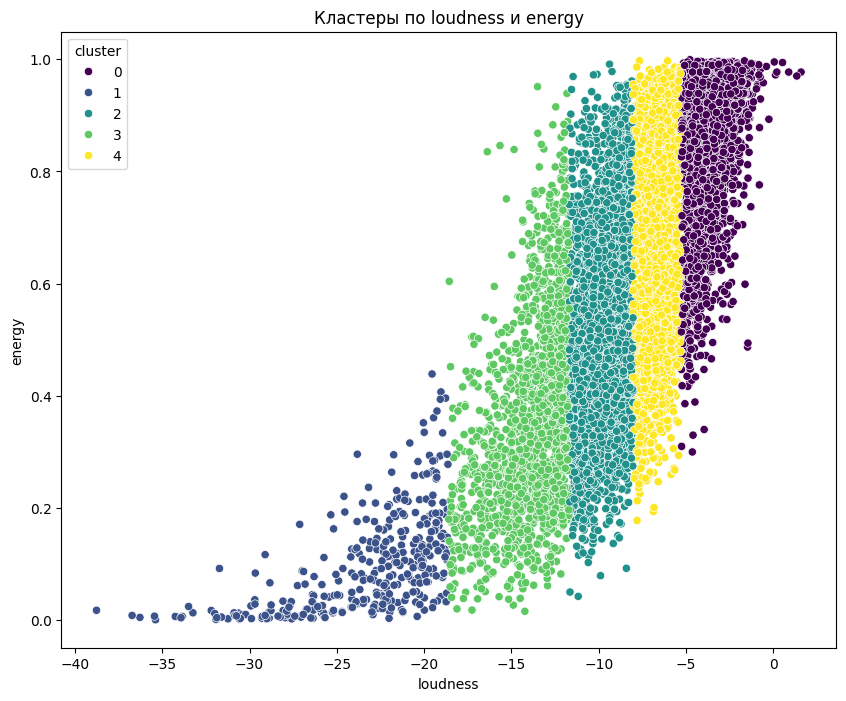

In [ ]:
# Визуализируем кластеры для параметров "энергичность" и громкость
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='loudness', y='energy', hue='cluster', palette='viridis')
plt.title('Кластеры по loudness и energy')
plt.show()

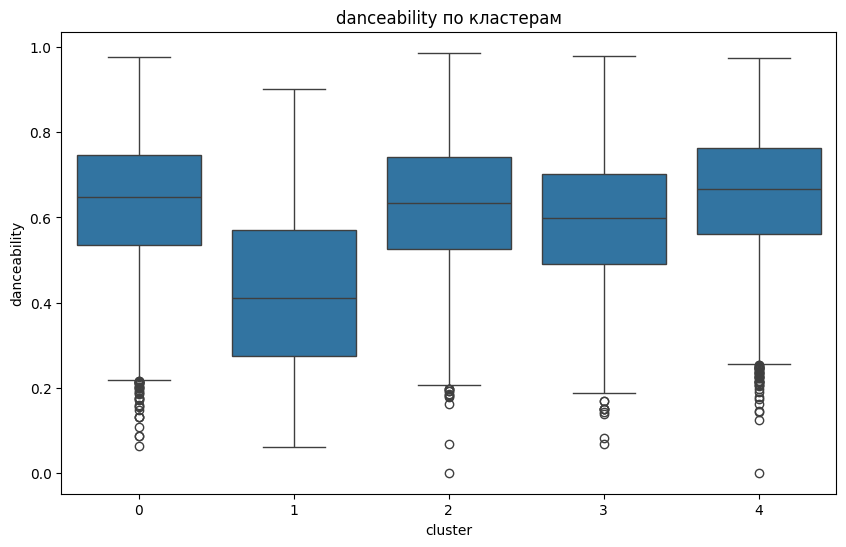

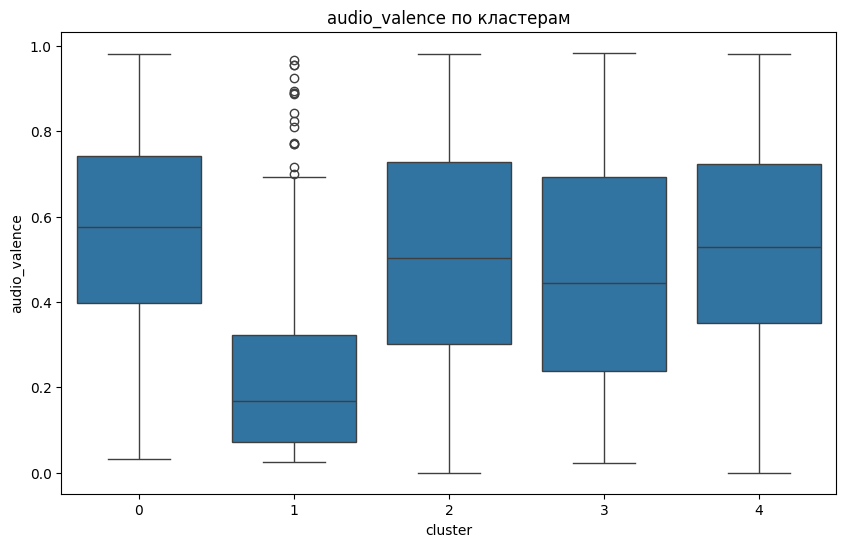

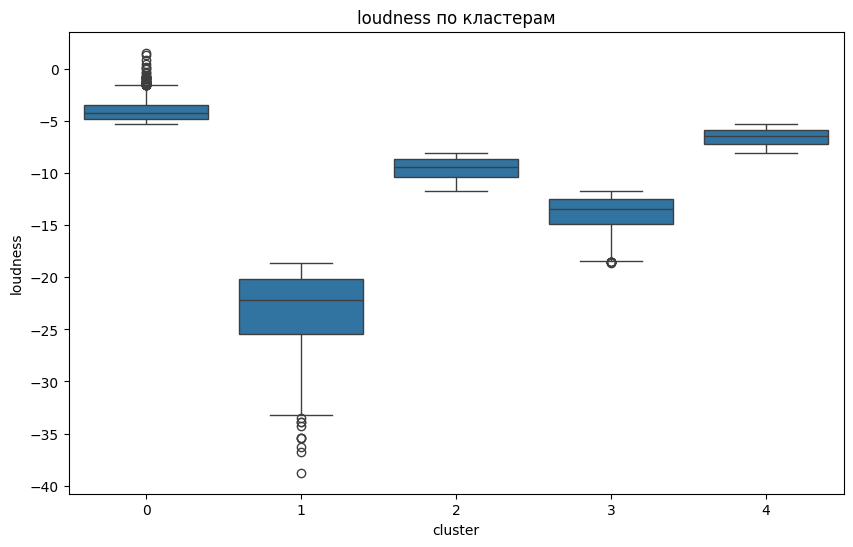

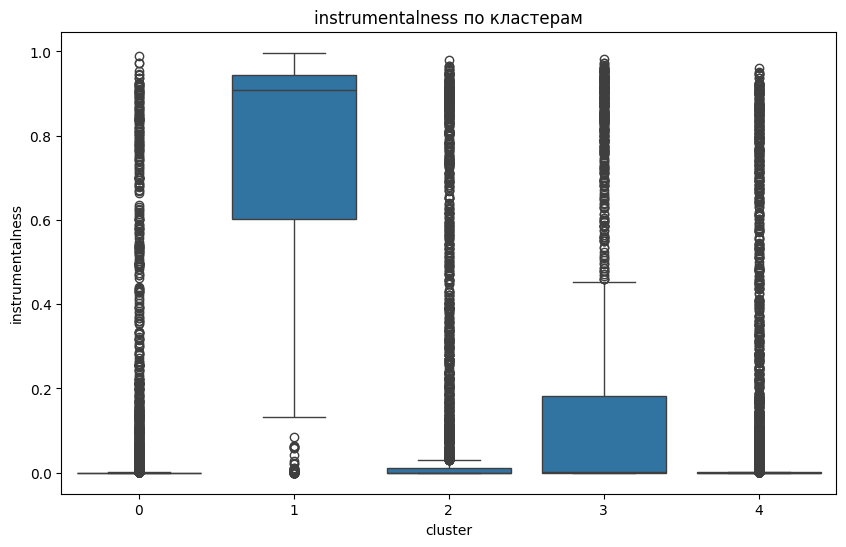

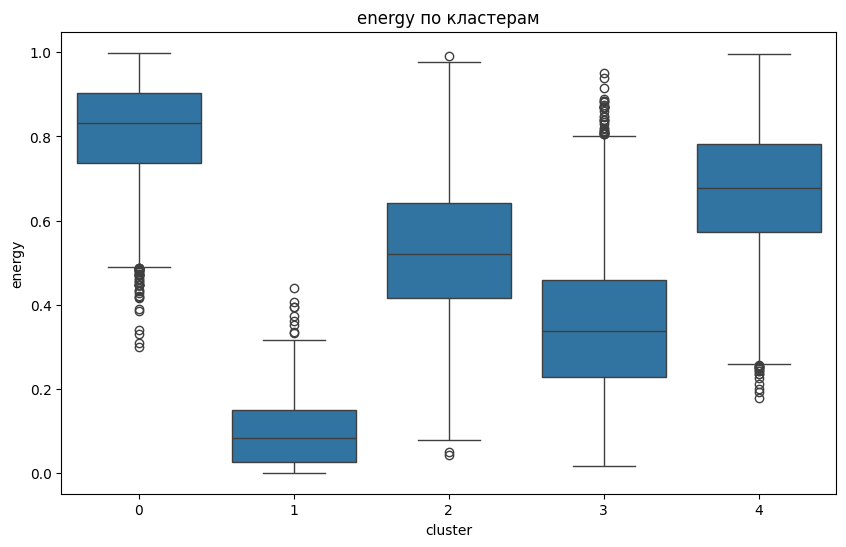

In [ ]:
# Оценим наши параметры в каждом кластере
for column in ['danceability', 'audio_valence', 'loudness', 'instrumentalness', 'energy']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=column, data=data)
    plt.title(f'{column} по кластерам')
    plt.show()

Средние значения популярности в кластерах:
         song_popularity
cluster                 
0              55.761624
1              51.609827
2              50.130519
3              47.714206
4              53.859988



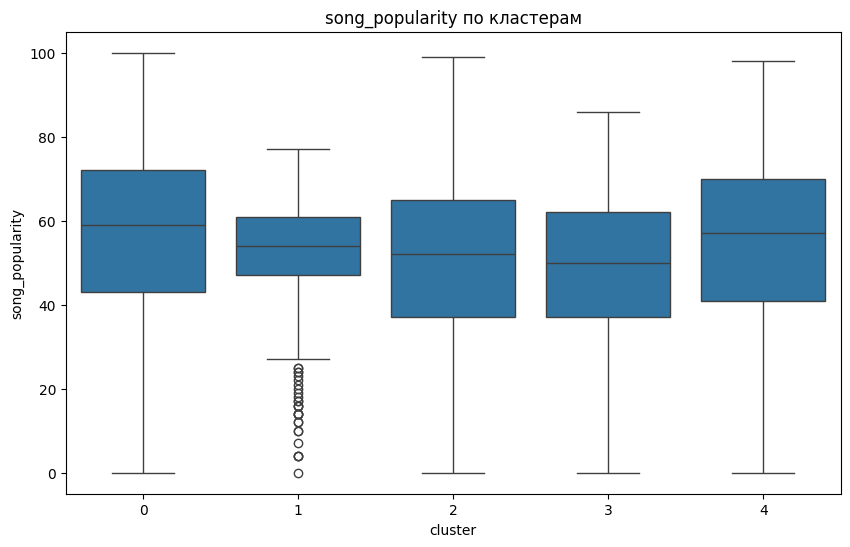

In [ ]:
# Посчитаем популярность песен во всех кластерах
mean_values = data.groupby('cluster')[['song_popularity']].mean()
print("Средние значения популярности в кластерах:")
print(mean_values)

print("")

# Оценим популярность песен в каждом кластере
for column in ['song_popularity']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=column, data=data)
    plt.title(f'{column} по кластерам')
    plt.show()

##Выводы

По полученным данным можно сделать следующие выводы и попробовать распределить кластеры и песни в них на определённые жанры музыки. Возьмём также 5 жанром: рок, поп, блюз, джаз и классика.

###**Кластеры**:
 - Кластер №0:
    
    - Второй по величине
    - Самый высокий средний и максимальный показатель по "энергичности" и громкости
    - Второй по "танцевальности"
    - Самый "популярный" кластер (самая высокая средняя популярность песен)

 - Кластер №1:
    
    - Последний по величине
    - Самый тихий кластер (наименьшая средняя громкость)
    - Первый по параметру "инструментальность" (среднее значение)
    - Последний по сочетанию звуков и "энергичности"


 - Кластер №2:
    
    - Третий по величине
    - Самый средний кластер по всем значениям


 - Кластер №3:
    
    - Четвёртый по величине
    - Самый непопулярный кластер (самая низкая средняя популярность песен)
    - Второй по параметру "инструментальность"

 - Кластер №4:
    
    - Первый по величине
    - Первый по параметру "танцевальность"
    - Последний по параметру "инструментальности"
    - Второй по популярности




### **Жанры**

С подробностями кластеров разобрались, самое время определять их жанры.

 - Кластер №0 - рок. Самые громкие и энергичные песни находятся в этом кластере. Самые популярные песни оказались с жанром "рок".

 - Кластер №1 - классика. Самый тихий и спокойный кластер. Большой упор на "инструментальность" песен.

 - Кластер №2 - джаз. Средний хороший уровень.

 - Кластер №3 - блюз. Мало кто слушает, но в среднем как блюз, также упор на "инструментальность".

 - Кластер №4 - поп. Самый большой кластер, никакой "инструментальности", но зато под эти песни лучше всего получается танцевать. Второй по популярности после рока.